# Benchmarking the disaggregated data

The goal is to confirm that the disaggregated data set gathered from the Census APIs and cds matches the published total import numbers on the Census website.  


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

The function reads in each monthly file and returns the sum of `GEN_VAL_MO`. The variable name changes in 2009 (`MO` to `MON`) so we need to deal with that.

In [2]:
def total_imports(fpath, m, y):
    var_names = pd.read_csv(fpath, nrows=1).columns.to_list()
    if 'GEN_VAL_MO' in var_names:
        df = pd.read_csv(fpath, usecols=['GEN_VAL_MO'])
    if 'GEN_VAL_MON' in var_names:
        df = pd.read_csv(fpath, usecols=['GEN_VAL_MON'])
        df = df.rename(columns={'GEN_VAL_MON': 'GEN_VAL_MO'})
    
    df['date'] = dt.datetime(y, int(m), 1)
    return  df[['date', 'GEN_VAL_MO']].groupby(['date']).sum()

In [6]:
months = ['0'+str(i) for i in range(1,10)] + [str(i) for i in range(10,13)]

df = pd.DataFrame()
for y in range(1990, 2013):
    print(y, end=' ')
    for m in months:
        print(m, end=' ')
        if str(y)+'-'+m not in ['2003-04', '2010-06', '2012-05']:
            fpath = 'Original data/census from cds/' + str(y) + '/' + str(y) + '-' + m + '.csv'
            df = df.append(total_imports(fpath, m, y))
    print('\n')


for y in range(2013, 2021):
    print(y, end=' ')
    for m in months:
        print(m, end=' ')
        fpath = 'Original data/census downloads/' + str(y) + '/' + str(y) + '-' + m + '.csv'
        df = df.append(total_imports(fpath, m, y))
    print('\n')

1990 01 02 03 04 05 06 07 08 09 10 11 12 

1991 01 02 03 04 05 06 07 08 09 10 11 12 

1992 01 02 03 04 05 06 07 08 09 10 11 12 

1993 01 02 03 04 05 06 07 08 09 10 11 12 

1994 01 02 03 04 05 06 07 08 09 10 11 12 

1995 01 02 03 04 05 06 07 08 09 10 11 12 

1996 01 02 03 04 05 06 07 08 09 10 11 12 

1997 01 02 03 04 05 06 07 08 09 10 11 12 

1998 01 02 03 04 05 06 07 08 09 10 11 12 

1999 01 02 03 04 05 06 07 08 09 10 11 12 

2000 01 02 03 04 05 06 07 08 09 10 11 12 

2001 01 02 03 04 05 06 07 08 09 10 11 12 

2002 01 02 03 04 05 06 07 08 09 10 11 12 

2003 01 02 03 04 05 06 07 08 09 10 11 12 

2004 01 02 03 04 05 06 07 08 09 10 11 12 

2005 01 02 03 04 05 06 07 08 09 10 11 12 

2006 01 02 03 04 05 06 07 08 09 10 11 12 

2007 01 02 03 04 05 06 07 08 09 10 11 12 

2008 01 02 03 04 05 06 07 08 09 10 11 12 

2009 01 02 03 04 05 06 07 08 09 10 11 12 

2010 01 02 03 04 05 06 07 08 09 10 11 12 

2011 01 02 03 04 05 06 07 08 09 10 11 12 

2012 01 02 03 04 05 06 07 08 09 10 11 12 

2013 01 02 

## Compare to published aggregates on Census website

These are the not-seasonally adjusted aggregate data series from the [census website.](https://www.census.gov/foreign-trade/balance/c0015.html) The link is at the very bottom of the page: "DOWNLOAD: Download the full..."

In [4]:
bench = pd.read_excel('https://www.census.gov/foreign-trade/balance/country.xlsx', dtype={'CTY_CODE':'object'})
bench = bench[bench['CTY_CODE']=='0015']
bench = bench.set_index(['year', 'CTYNAME', 'CTY_CODE']).stack().reset_index()
bench.columns = ['year', 'country', 'ccode', 'monthvar', 'value']
bench['var'] = bench['monthvar'].str.slice(0,1)
bench['month'] = bench['monthvar'].str.slice(1,4)
bench = bench[bench['month']!='YR']
bench['date'] = bench['year'].astype(str) + '-' + bench['month']
bench['date'] = pd.to_datetime(bench['date'], format='%Y-%b')
bench = bench.set_index('date')
bench = bench[bench['var']=='I']
bench.head()


,year,country,ccode,monthvar,value,var,month
date,,,,,,,
1987-01-01,1987,"World, Not Seasonally Adjusted",0015,IJAN,30798.5,I,JAN
1987-02-01,1987,"World, Not Seasonally Adjusted",0015,IFEB,29810.3,I,FEB
1987-03-01,1987,"World, Not Seasonally Adjusted",0015,IMAR,32464.3,I,MAR
1987-04-01,1987,"World, Not Seasonally Adjusted",0015,IAPR,32291.1,I,APR
1987-05-01,1987,"World, Not Seasonally Adjusted",0015,IMAY,33170.0,I,MAY


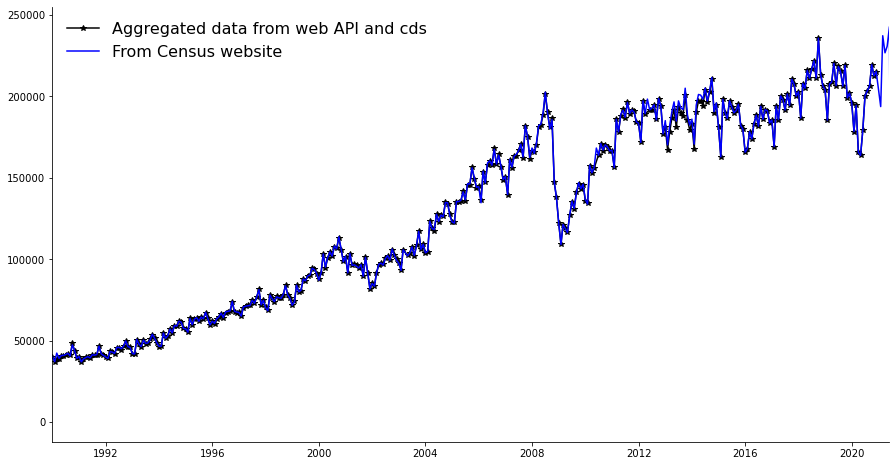

In [7]:
fig, ax = plt.subplots(figsize=(15,8))

ax.plot(df.index, df['GEN_VAL_MO']/1000000, color='black', marker = '*', label = 'Aggregated data from web API and cds')
ax.plot(bench.index, bench['value'], color='blue', label = 'From Census website')

ax.set_xlim(dt.datetime(1990, 1, 1), dt.datetime(2021, 6, 1))
#ax.set_ylim(150000)

ax.legend(frameon=False, fontsize=16)
sns.despine()

In [17]:
error = df['GEN_VAL_MO']/ 1000000 / bench.loc['1990':'2020', 'value']

In [32]:
error.loc['1990-02-01']

1.0006717742826425

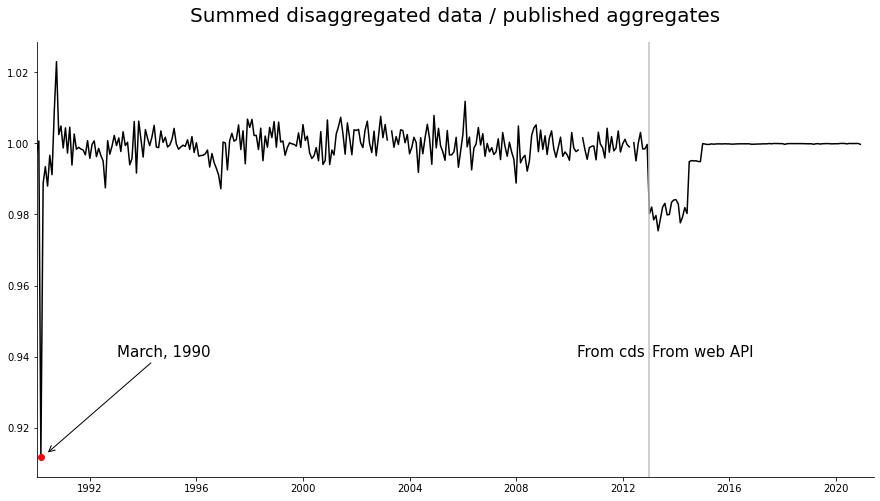

In [59]:
fig, ax = plt.subplots(figsize=(15,8))

ax.plot(error.index, error, color='black')


ax.axvline(x=dt.datetime(2013,1,1), color='silver')
ax.text(dt.datetime(2013, 2,1), 0.94,'From web API', fontsize=15, ha='left')
ax.text(dt.datetime(2012, 11,1), 0.94,'From cds', fontsize=15, ha='right')

ax.plot(dt.datetime(1990,3,1), error.loc['1990-03-01'], marker='o', color='red')
ax.annotate('March, 1990', 
            xy=(dt.datetime(1990,5,15),error.loc['1990-03-01']*1.001), 
            xytext=(dt.datetime(1993,1,1), 0.94),
            arrowprops={'arrowstyle':'->'},
            fontsize=15)

ax.set_title('Summed disaggregated data / published aggregates', fontsize=20, pad=20)

ax.set_xlim(dt.datetime(1990, 1, 1), dt.datetime(2021, 6, 1))

sns.despine()

The differences from the CDs look mostly like noise and likely represent revisions to the data that could not be included after the cds were pressed. The March 1990 data is the largest outlier and something I need to look into. 

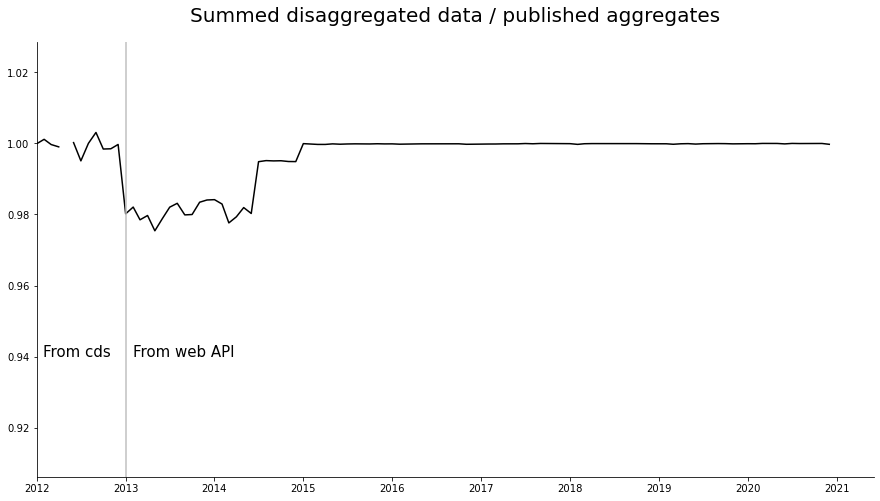

In [58]:
fig, ax = plt.subplots(figsize=(15,8))

ax.plot(error.index, error, color='black')


ax.axvline(x=dt.datetime(2013,1,1), color='silver')
ax.text(dt.datetime(2013, 2,1), 0.94,'From web API', fontsize=15, ha='left')
ax.text(dt.datetime(2012, 11,1), 0.94,'From cds', fontsize=15, ha='right')

ax.set_xlim(dt.datetime(2012, 1, 1), dt.datetime(2021, 6, 1))

ax.set_title('Summed disaggregated data / published aggregates', fontsize=20, pad=20)

sns.despine()

By 2015, the two series are just about identical. The 2013--2014 data deviate from the published aggregates, which is harder to understand, given that the data are available from the Census servers...